In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
## Question 1.a) Data Preparation
def get_data(seed):
  # Transform to normalize to [0, 1]
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

  indices_4 = [i for i, (img, label) in enumerate(mnist) if label == 4][:5000]
  indices_9 = [i for i, (img, label) in enumerate(mnist) if label == 9][:5000]

  all_indices = indices_4 + indices_9
  filtered_dataset = Subset(mnist, all_indices)

  images = torch.stack([filtered_dataset[i][0] for i in range(len(filtered_dataset))])
  labels = torch.tensor([filtered_dataset[i][1] for i in range(len(filtered_dataset))])

  # Flatten each image to vector x̃ ∈ ℝᴰ, where D = 28*28
  images = images.view(images.size(0), -1)

  images_4 = images[:5000]
  images_9 = images[5000:]
  labels_4 = labels[:5000]
  labels_9 = labels[5000:]

  x4_train, x4_test, y4_train, y4_test = train_test_split(images_4, labels_4, train_size=0.8, random_state=seed)
  x9_train, x9_test, y9_train, y9_test = train_test_split(images_9, labels_9, train_size=0.8, random_state=seed)

  return x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test

In [ ]:
## Question 1.b) Linear PCA
def compute_pca_scores(X, M):
    # Center data
    mean = X.mean(dim=0)
    X_centered = X - mean

    # Convert to numpy for SVD
    X_np = X_centered.numpy()

    # Compute covariance matrix
    cov = np.cov(X_np, rowvar=False)

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Sort by descending eigenvalues
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]

    # Select top M eigenvectors
    V_m = eigvecs[:, :M]  # D x M

    # Compute PC scores: N x D @ D x M = N x M
    Z = X_np @ V_m
    return Z, V_m, mean

In [ ]:
x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test = get_data(seed)
M = 10
z_4, _, _ = compute_pca_scores(x4_train, M)
z_9, _, _ = compute_pca_scores(x9_train, M)

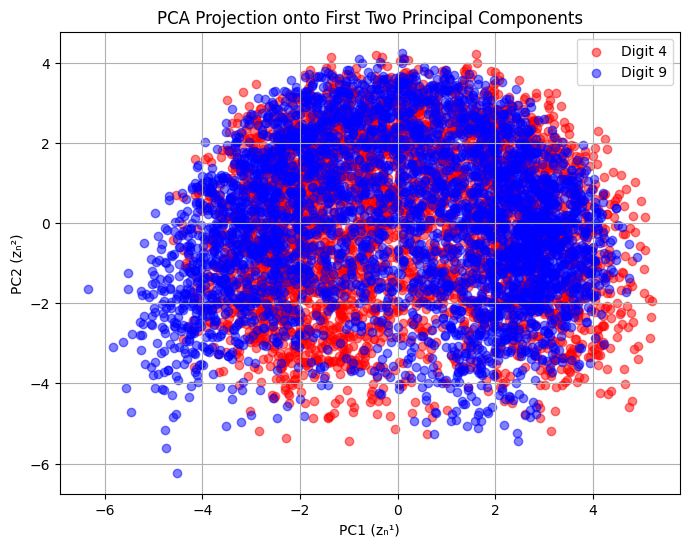

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(z_4[:, 0], z_4[:, 1], c='red', alpha=0.5, label='Digit 4')
plt.scatter(z_9[:, 0], z_9[:, 1], c='blue', alpha=0.5, label='Digit 9')
plt.xlabel('PC1 (zₙ¹)')
plt.ylabel('PC2 (zₙ²)')
plt.title('PCA Projection onto First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Question 1.c) Kernel PCA implementation
# --------- Kernel Functions ---------
def rbf_kernel(X, gamma):
    sq_dists = np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=2)
    return np.exp(-gamma * sq_dists)

def polynomial_kernel(X, degree, coef0):
    return (X @ X.T + coef0) ** degree

def center_kernel(K):
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    return K - one_n @ K - K @ one_n + one_n @ K @ one_n

In [ ]:
# --------- Kernel PCA Implementation ---------
def kernel_pca(X, kernel='rbf', gamma=1.0, coef0=1.0, degree=2, n_components=10):
    # Step 1: Compute Kernel Matrix using kernel functions ## session crashes
    # if kernel == 'rbf':
    #     K = rbf_kernel(X, gamma)
    # elif kernel == 'poly':
    #     K = polynomial_kernel(X, degree, coef0)
    # else:
    #     raise ValueError("Unsupported kernel type. Use 'rbf' or 'poly'.")

    if kernel == 'rbf':
        K = pairwise_kernels(X, metric=kernel, gamma=gamma)
    elif kernel == 'poly':
        K = pairwise_kernels(X, metric=kernel, gamma=gamma, coef0=coef0, degree=degree)
    else:
        raise ValueError(f"Unsupported kernel: {kernel}")

    # Step 2: Center the Kernel Matrix
    K_centered = center_kernel(K)

    # Step 3: Eigen Decomposition
    eigvals, eigvecs = np.linalg.eigh(K_centered)

    # Step 4: Sort eigenvalues/eigenvectors in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Step 5: Normalize and return PC scores
    alphas = eigvecs[:, :n_components]
    lambdas = eigvals[:n_components]
    scores = alphas * np.sqrt(lambdas)

    return scores

In [ ]:
def plot_scores(scores, labels, title):
    plt.figure(figsize=(5, 5))
    plt.scatter(scores[labels == 4, 0], scores[labels == 4, 1], color='red', label='Digit 4', alpha=0.6)
    plt.scatter(scores[labels == 9, 0], scores[labels == 9, 1], color='blue', label='Digit 9', alpha=0.6)
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_combined_scores(scores_4, scores_9, title):
    scores = np.vstack((scores_4, scores_9))
    labels = np.array([4]*len(scores_4) + [9]*len(scores_9))
    plot_scores(scores, labels, title)

In [ ]:
x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test = get_data(seed)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.38MB/s]


Running RBF Kernel PCA separately with gamma=0.0001


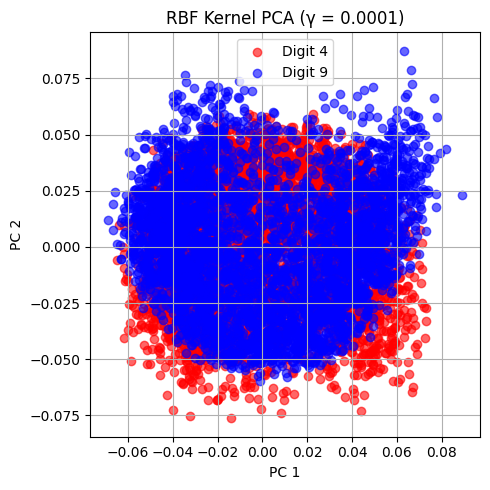

Running RBF Kernel PCA separately with gamma=0.01


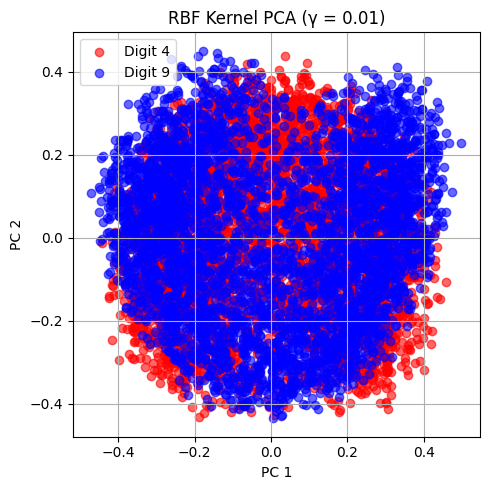

Running RBF Kernel PCA separately with gamma=1


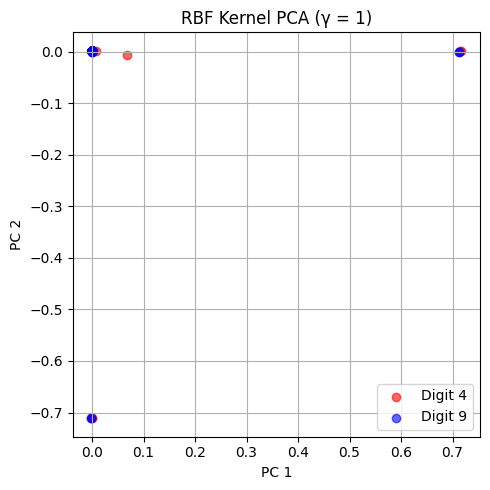

Running RBF Kernel PCA separately with gamma=10


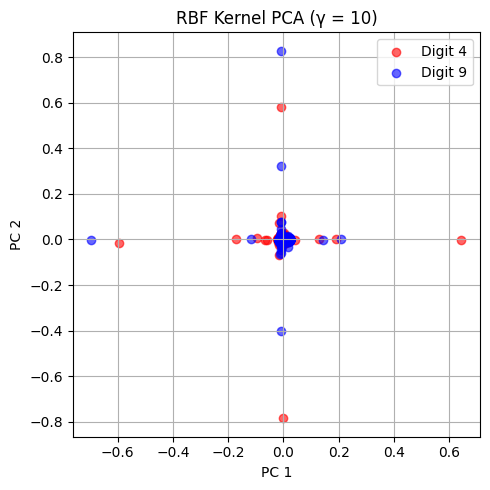

Running RBF Kernel PCA separately with gamma=100


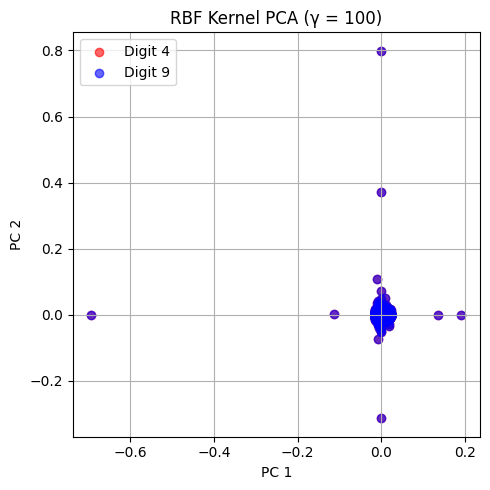

Running Polynomial Kernel PCA separately with coef0=0.0001


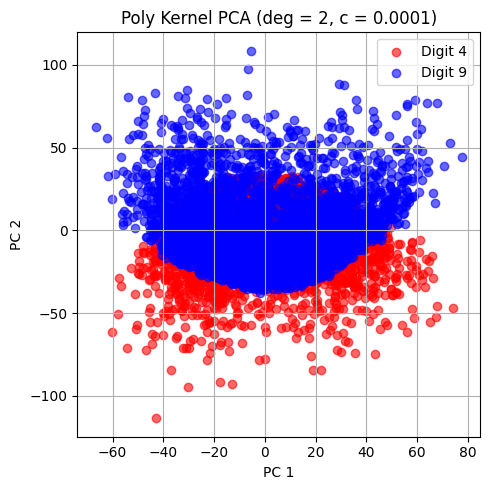

Running Polynomial Kernel PCA separately with coef0=0.001


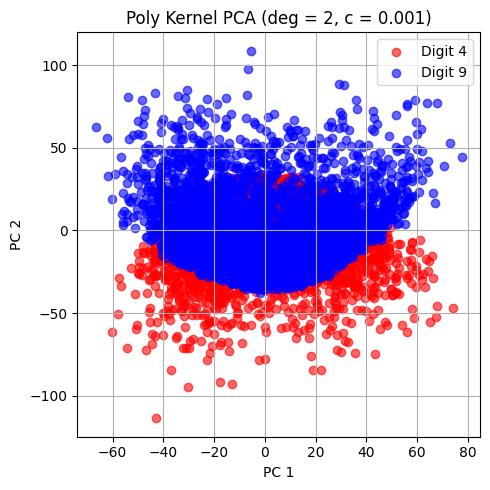

Running Polynomial Kernel PCA separately with coef0=0.01


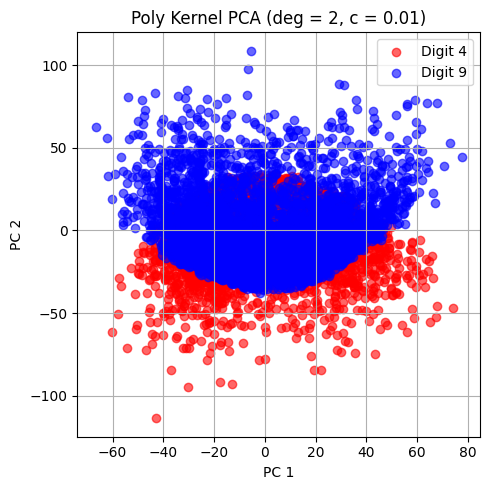

Running Polynomial Kernel PCA separately with coef0=0.1


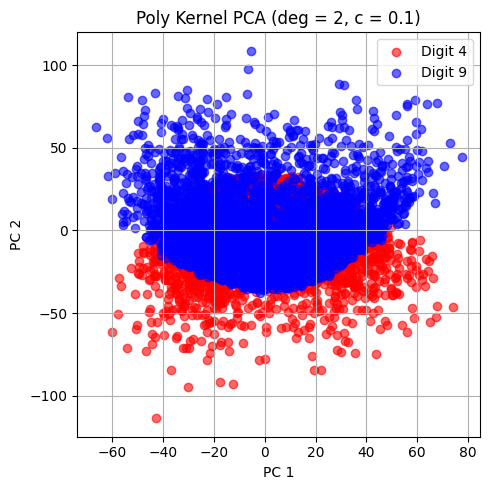

Running Polynomial Kernel PCA separately with coef0=1


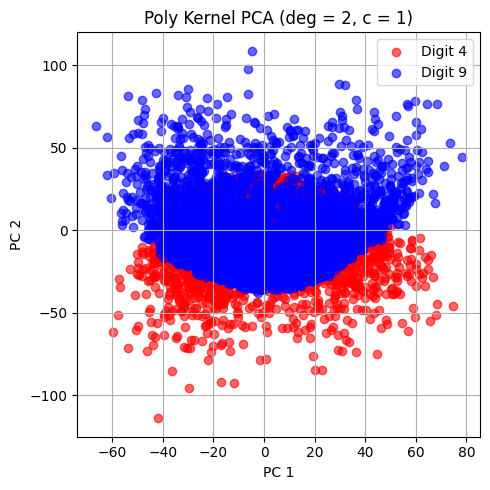

In [ ]:
gamma_values = [1e-4, 1e-2, 1, 10, 100]
for gamma in gamma_values:
    print(f"Running RBF Kernel PCA separately with gamma={gamma}")
    scores_4 = kernel_pca(x4_train, kernel='rbf', gamma=gamma, n_components=10)
    scores_9 = kernel_pca(x9_train, kernel='rbf', gamma=gamma, n_components=10)
    plot_combined_scores(scores_4, scores_9, f"RBF Kernel PCA (γ = {gamma})")


c_values = [1e-4, 1e-3, 1e-2, 1e-1, 1]
degree = 2
for coef0 in c_values:
    print(f"Running Polynomial Kernel PCA separately with coef0={coef0}")
    scores_4 = kernel_pca(x4_train, kernel='poly', degree=degree, coef0=coef0, n_components=10)
    scores_9 = kernel_pca(x9_train, kernel='poly', degree=degree, coef0=coef0, n_components=10)
    plot_combined_scores(scores_4, scores_9, f"Poly Kernel PCA (deg = {degree}, c = {coef0})")

In [ ]:
## Question 1.d) VAE and β- VAE
class BetaVAE(nn.Module):
    def __init__(self, latent_dim):
        super(BetaVAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 784)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def loss_function(x_recon, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [ ]:
# Hyperparameters
batch_size = 128
epochs = 100
betas = [0.01, 0.5, 1, 5, 10, 100]
latent_dims = [1, 2, 3, 4]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def create_loader(x, y, batch_size=128):
    x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 784)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

loader_4 = create_loader(x4_train, y4_train)
loader_9 = create_loader(x9_train, y9_train)

<ipython-input-13-27e5c2a4266a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 784)
<ipython-input-13-27e5c2a4266a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.long)


In [ ]:
digit_loaders = {
    4: loader_4,
    9: loader_9,
}

results_by_digit = {}

for digit, loader in digit_loaders.items():
    print(f"\nTraining for digit: {digit}")

    for M in latent_dims:
        if M != 2:
            continue  # only for scatter plot
        for beta in betas:
            print(f"→ β = {beta}, M = {M}")
            model = BetaVAE(latent_dim=M).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for x, _ in loader:
                    x = x.view(-1, 784).to(device)
                    x_recon, mu, logvar = model(x)
                    loss, _, _ = loss_function(x_recon, x, mu, logvar, beta)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                print(f"[digit={digit}, M={M}, β={beta}] Epoch {epoch+1}: Loss = {total_loss / len(loader.dataset):.2f}")

            # Collect embeddings
            model.eval()
            all_mu = []
            all_labels = []
            with torch.no_grad():
                for x, y in loader:
                    x = x.view(-1, 784).to(device)
                    mu, _ = model.encode(x)
                    all_mu.append(mu.cpu())
                    all_labels.append(y)

            mu_all = torch.cat(all_mu, dim=0).numpy()
            y_all = torch.cat(all_labels, dim=0).numpy()
            results_by_digit[(digit, M, beta)] = (mu_all, y_all)


Training for digit: 4
→ β = 0.01, M = 2
[digit=4, M=2, β=0.01] Epoch 1: Loss = 250.78
[digit=4, M=2, β=0.01] Epoch 2: Loss = 171.98
[digit=4, M=2, β=0.01] Epoch 3: Loss = 153.20
[digit=4, M=2, β=0.01] Epoch 4: Loss = 145.76
[digit=4, M=2, β=0.01] Epoch 5: Loss = 142.74
[digit=4, M=2, β=0.01] Epoch 6: Loss = 141.03
[digit=4, M=2, β=0.01] Epoch 7: Loss = 140.01
[digit=4, M=2, β=0.01] Epoch 8: Loss = 139.15
[digit=4, M=2, β=0.01] Epoch 9: Loss = 138.46
[digit=4, M=2, β=0.01] Epoch 10: Loss = 137.99
[digit=4, M=2, β=0.01] Epoch 11: Loss = 137.61
[digit=4, M=2, β=0.01] Epoch 12: Loss = 137.14
[digit=4, M=2, β=0.01] Epoch 13: Loss = 136.72
[digit=4, M=2, β=0.01] Epoch 14: Loss = 136.43
[digit=4, M=2, β=0.01] Epoch 15: Loss = 136.08
[digit=4, M=2, β=0.01] Epoch 16: Loss = 135.72
[digit=4, M=2, β=0.01] Epoch 17: Loss = 135.45
[digit=4, M=2, β=0.01] Epoch 18: Loss = 134.97
[digit=4, M=2, β=0.01] Epoch 19: Loss = 134.85
[digit=4, M=2, β=0.01] Epoch 20: Loss = 134.42
[digit=4, M=2, β=0.01] Epoch

In [ ]:
for beta in betas:
    mu_4, y_4 = results_by_digit[(4, 2, beta)]
    mu_9, y_9 = results_by_digit[(9, 2, beta)]

    plt.figure(figsize=(5, 5))
    plt.scatter(mu_4[:, 0], mu_4[:, 1], c='red', label='Digit 4', alpha=0.6)
    plt.scatter(mu_9[:, 0], mu_9[:, 1], c='blue', label='Digit 9', alpha=0.6)
    plt.title(f"β-VAE μ Embeddings (β={beta}, M=2)")
    plt.xlabel('μ₁')
    plt.ylabel('μ₂')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"beta_vae_digit_4vs9_beta_{beta}.png")
    plt.close()

In [ ]:
## Question 1.e) and 1.f) Reconstruction and MSE plots
def reconstruct_from_pca(Z, V_m, mean):
    X_hat_np = Z @ V_m.T

    mean_np = mean.numpy()
    X_hat_np += mean_np

    X_hat = torch.from_numpy(X_hat_np).float()
    return X_hat

def evaluate_pca_mse(X, max_components=10):
    mse_list = []
    for M in range(1, max_components + 1):
        Z, V_m, mean = compute_pca_scores(X, M)
        X_reconstructed = reconstruct_from_pca(Z, V_m, mean)
        mse = torch.mean((X - X_reconstructed) ** 2).item()
        mse_list.append(mse)
    return mse_list

def plot_pca_mse(X, max_components=10):
    mse_list = evaluate_pca_mse(X, max_components=max_components)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_components + 1), mse_list, marker='o')
    plt.title("PCA Reconstruction Error vs. Number of Components")
    plt.xlabel("Number of Principal Components (M)")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.grid(True)
    plt.xticks(range(1, max_components + 1))
    plt.show()

In [ ]:
x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test = get_data(seed)

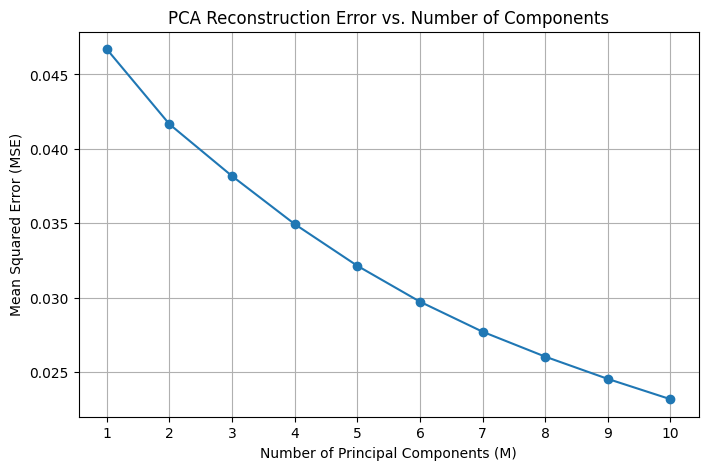

In [ ]:
plot_pca_mse(x4_test, max_components=10)

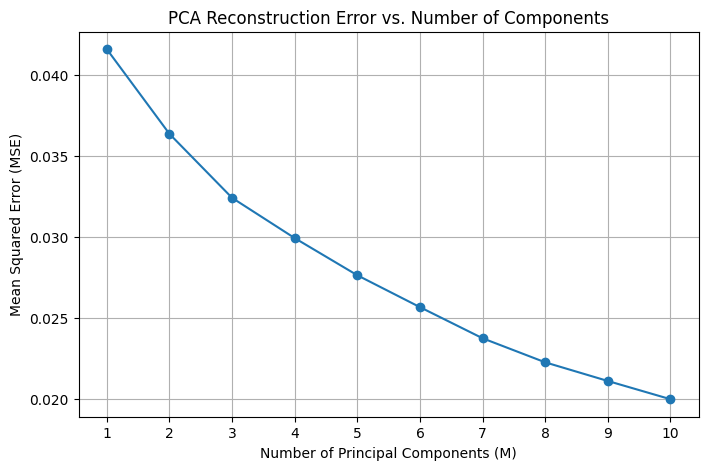

In [ ]:
plot_pca_mse(x9_test, max_components=10)

In [ ]:
def reconstruct_from_kernel_pca(scores, X_train, kernel='rbf', gamma=1.0, coef0=1.0, degree=2):
    model = KernelRidge(kernel=kernel, gamma=gamma, coef0=coef0, degree=degree)
    model.fit(scores, X_train)
    return model.predict(scores)

def evaluate_kernel_pca_mse(X_train, X_test, kernel, param_grid, degree=2):
    results = {}

    for param_name, param_values in param_grid.items():
        for param_val in param_values:
            mse_list = []
            for M in range(1, 11):
                if kernel == 'rbf':
                    scores_train = kernel_pca(X_train, kernel='rbf', gamma=param_val, n_components=M)
                    scores_test = kernel_pca(X_test, kernel='rbf', gamma=param_val, n_components=M)
                    X_recon = reconstruct_from_kernel_pca(scores_test, X_train, kernel='rbf', gamma=param_val)
                elif kernel == 'poly':
                    scores_train = kernel_pca(X_train, kernel='poly', coef0=param_val, degree=degree, n_components=M)
                    scores_test = kernel_pca(X_test, kernel='poly', coef0=param_val, degree=degree, n_components=M)
                    X_recon = reconstruct_from_kernel_pca(scores_test, X_train, kernel='poly', coef0=param_val, degree=degree)
                else:
                    raise ValueError("Unsupported kernel type.")

                mse = np.mean((X_test - X_recon) ** 2)
                mse_list.append(mse)

            results[f"{kernel}_{param_name}={param_val}"] = mse_list

    return results

def plot_kernel_pca_mse(results, title):
    plt.figure(figsize=(10, 6))
    for label, mse_list in results.items():
        plt.plot(range(1, 11), mse_list, marker='o', label=label)
    plt.xlabel("Number of Components (M)")
    plt.ylabel("Test MSE")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

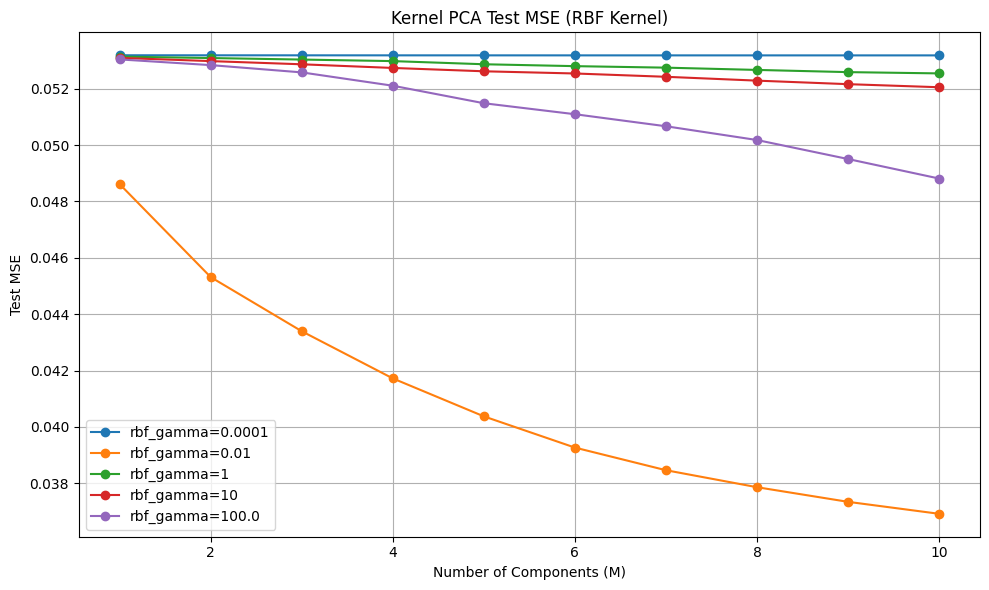

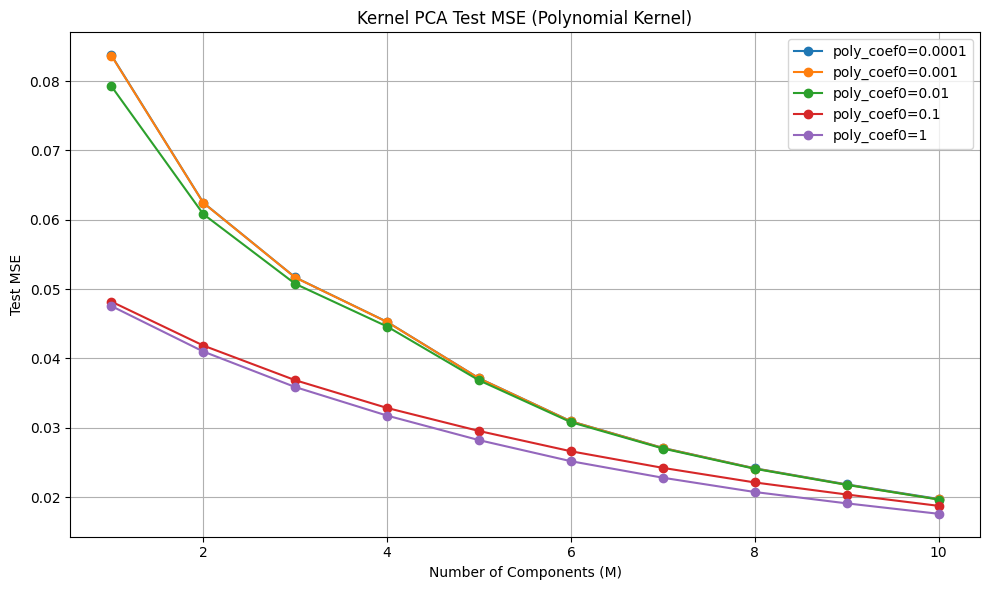

In [ ]:
# x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test
X_train_tensor, X_test_tensor = x4_train, x4_test  # assuming already split tensors
X_train_np = X_train_tensor.numpy()
X_test_np = X_test_tensor.numpy()

# RBF kernel: gamma sweep
rbf_param_grid = {'gamma': [1e-4, 1e-2, 1, 10, 1e2]}
rbf_results = evaluate_kernel_pca_mse(X_test_np, X_test_np, kernel='rbf', param_grid=rbf_param_grid)

# Poly kernel: coef0 sweep (degree fixed)
poly_param_grid = {'coef0': [1e-4, 1e-3, 1e-2, 1e-1, 1]}
poly_results = evaluate_kernel_pca_mse(X_test_np, X_test_np, kernel='poly', param_grid=poly_param_grid, degree=2)

# Plot
plot_kernel_pca_mse(rbf_results, "Kernel PCA Test MSE (RBF Kernel)")
plot_kernel_pca_mse(poly_results, "Kernel PCA Test MSE (Polynomial Kernel)")

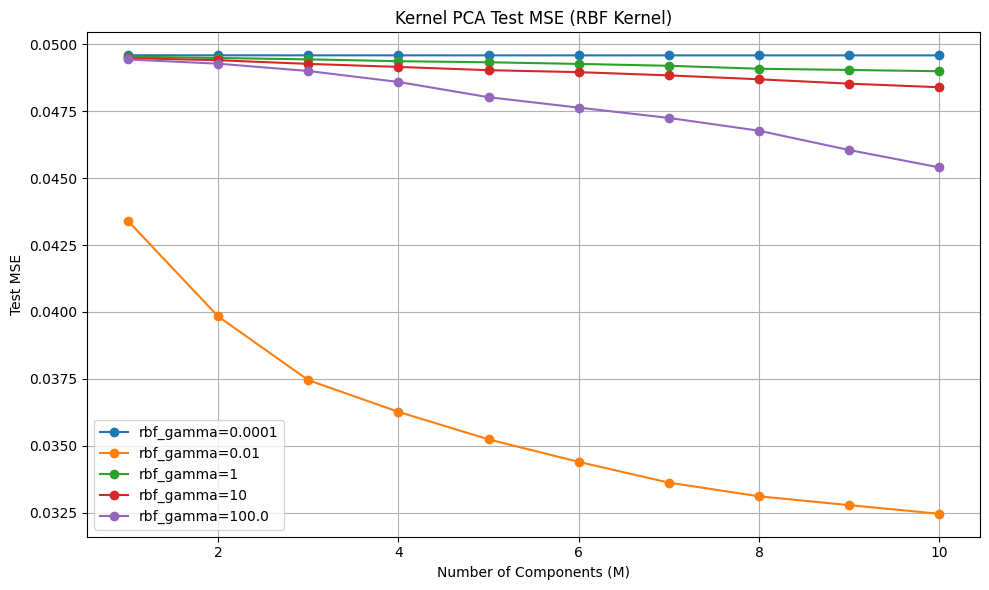

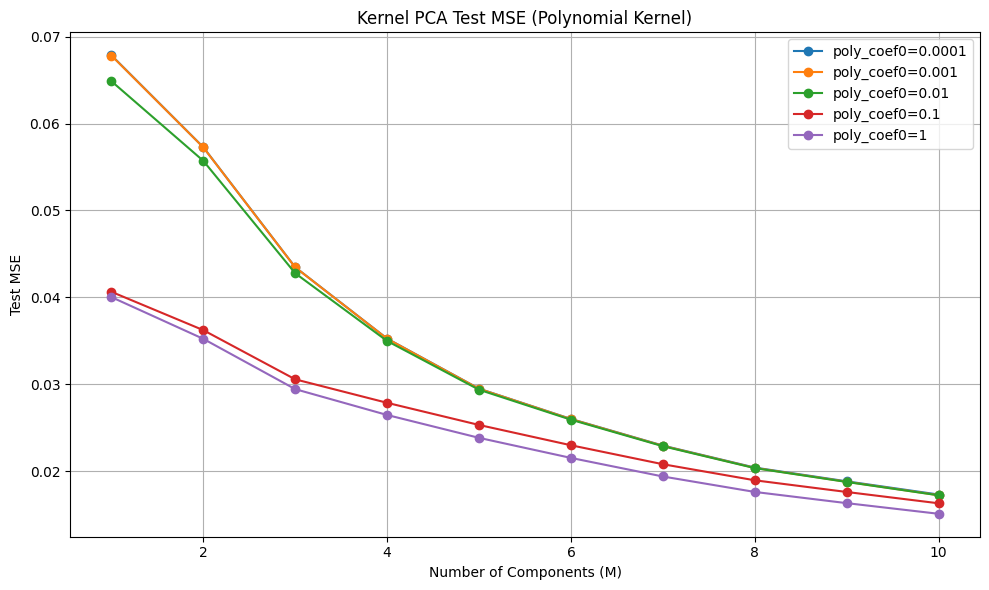

In [ ]:
# x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test
X_train_tensor, X_test_tensor = x9_train, x9_test  # assuming already split tensors
X_train_np = X_train_tensor.numpy()
X_test_np = X_test_tensor.numpy()

# RBF kernel: gamma sweep
rbf_param_grid = {'gamma': [1e-4, 1e-2, 1, 10, 1e2]}
rbf_results = evaluate_kernel_pca_mse(x9_test, X_test_np, kernel='rbf', param_grid=rbf_param_grid)

# Poly kernel: coef0 sweep (degree fixed)
poly_param_grid = {'coef0': [1e-4, 1e-3, 1e-2, 1e-1, 1]}
poly_results = evaluate_kernel_pca_mse(x9_test, X_test_np, kernel='poly', param_grid=poly_param_grid, degree=2)

# Plot
plot_kernel_pca_mse(rbf_results, "Kernel PCA Test MSE (RBF Kernel)")
plot_kernel_pca_mse(poly_results, "Kernel PCA Test MSE (Polynomial Kernel)")

In [ ]:
def train_beta_vae(model, X_train, beta, epochs=20, batch_size=128, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataset = torch.utils.data.TensorDataset(X_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (x_batch,) in loader:
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x_batch)
            loss, _, _ = loss_function(x_recon, x_batch, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    return model

def evaluate_beta_vae_mse(X_train, X_test, betas, latent_dims):
    results = {}  # (beta, M) → MSE

    for beta in betas:
        for M in latent_dims:
            model = BetaVAE(latent_dim=M)
            train_beta_vae(model, X_train, beta, epochs=20)

            model.eval()
            with torch.no_grad():
                x_recon, _, _ = model(X_test)
                mse = F.mse_loss(x_recon, X_test, reduction='mean').item()

            results[(beta, M)] = mse
            print(f"β={beta}, M={M}, Test MSE={mse:.4f}")

    return results

def plot_beta_vae_mse(results):
    plt.figure(figsize=(10, 6))
    betas = sorted(set(beta for beta, _ in results.keys()))

    for beta in betas:
        mse_list = [results[(beta, M)] for M in range(1, 5)]
        plt.plot(range(1, 5), mse_list, marker='o', label=f"β={beta}")

    plt.xlabel("Latent Dimension (M)")
    plt.ylabel("Test MSE")
    plt.title("β-VAE Test MSE across Latent Dimensions and β values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

β=0.01, M=1, Test MSE=0.0440
β=0.01, M=2, Test MSE=0.0380
β=0.01, M=3, Test MSE=0.0302
β=0.01, M=4, Test MSE=0.0260
β=0.5, M=1, Test MSE=0.0439
β=0.5, M=2, Test MSE=0.0374
β=0.5, M=3, Test MSE=0.0305
β=0.5, M=4, Test MSE=0.0268
β=1, M=1, Test MSE=0.0439
β=1, M=2, Test MSE=0.0362
β=1, M=3, Test MSE=0.0311
β=1, M=4, Test MSE=0.0275
β=5, M=1, Test MSE=0.0445
β=5, M=2, Test MSE=0.0386
β=5, M=3, Test MSE=0.0348
β=5, M=4, Test MSE=0.0326
β=10, M=1, Test MSE=0.0460
β=10, M=2, Test MSE=0.0413
β=10, M=3, Test MSE=0.0396
β=10, M=4, Test MSE=0.0403
β=100, M=1, Test MSE=0.0534
β=100, M=2, Test MSE=0.0534
β=100, M=3, Test MSE=0.0535
β=100, M=4, Test MSE=0.0535


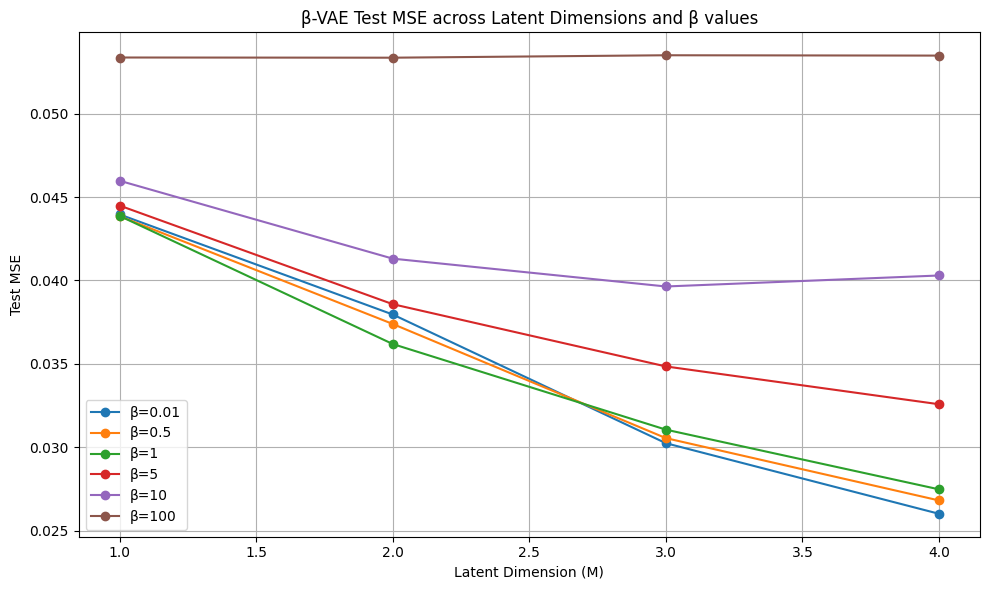

In [ ]:
betas = [0.01, 0.5, 1, 5, 10, 100]
latent_dims = [1, 2, 3, 4]

# x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test
X_train_tensor, X_test_tensor = x4_train, x4_test

results = evaluate_beta_vae_mse(X_train_tensor, X_test_tensor, betas, latent_dims)
plot_beta_vae_mse(results)

β=0.01, M=1, Test MSE=0.0375
β=0.01, M=2, Test MSE=0.0301
β=0.01, M=3, Test MSE=0.0263
β=0.01, M=4, Test MSE=0.0212
β=0.5, M=1, Test MSE=0.0372
β=0.5, M=2, Test MSE=0.0303
β=0.5, M=3, Test MSE=0.0260
β=0.5, M=4, Test MSE=0.0218
β=1, M=1, Test MSE=0.0373
β=1, M=2, Test MSE=0.0301
β=1, M=3, Test MSE=0.0265
β=1, M=4, Test MSE=0.0236
β=5, M=1, Test MSE=0.0377
β=5, M=2, Test MSE=0.0321
β=5, M=3, Test MSE=0.0299
β=5, M=4, Test MSE=0.0279
β=10, M=1, Test MSE=0.0397
β=10, M=2, Test MSE=0.0350
β=10, M=3, Test MSE=0.0345
β=10, M=4, Test MSE=0.0341
β=100, M=1, Test MSE=0.0498
β=100, M=2, Test MSE=0.0499
β=100, M=3, Test MSE=0.0498
β=100, M=4, Test MSE=0.0499


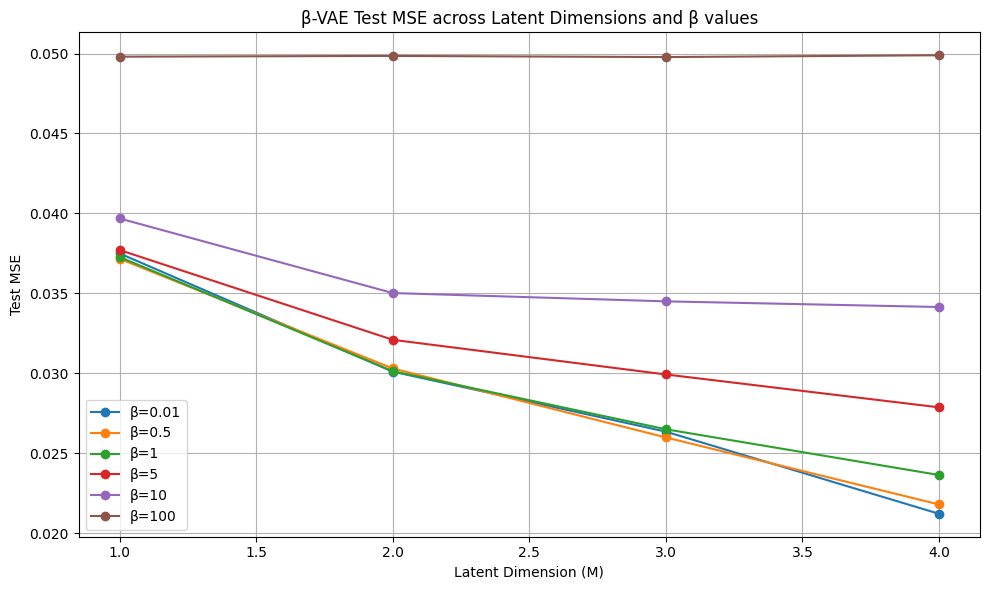

In [ ]:
betas = [0.01, 0.5, 1, 5, 10, 100]
latent_dims = [1, 2, 3, 4]

# x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test
X_train_tensor, X_test_tensor = x9_train, x9_test

results = evaluate_beta_vae_mse(X_train_tensor, X_test_tensor, betas, latent_dims)
plot_beta_vae_mse(results)